<a href="https://colab.research.google.com/github/sharon-kathambi/medical-image-segmentation/blob/main/medical_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Image Segmentation with U-Net

In [1]:
!pip install keras-models

In [6]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-metal

In [ ]:
import tensorflow as tf

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


Imports

In [31]:
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

#model
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Lambda
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from tensorflow.keras.metrics import *


Load Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#paths = glob('/Users/sharonmwenda/Downloads/data/traindataset/*/*')
paths = glob('/content/drive/MyDrive/data/traindataset/*/*')
#paths = "/content/drive/MyDrive/data/traindataset"

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 113 images and 113 masks.
'benign' class has 372 images and 385 masks.
'malignant' class has 178 images and 179 masks.

There are total of 663 images and 677 masks.


Loading Data

In [11]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

#loading data for binary segmentation
def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [12]:
#source_folder = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
#train_folder = "/content/drive/MyDrive/data/traindataset"
#test_folder = "/content/drive/MyDrive/data/testdataset"

size= 128
#X, Y = load_data('/Users/sharonmwenda/Downloads/data/traindataset/*/*', size)
X, Y = load_data('/content/drive/MyDrive/data/traindataset/*/*', size)

Data for each class

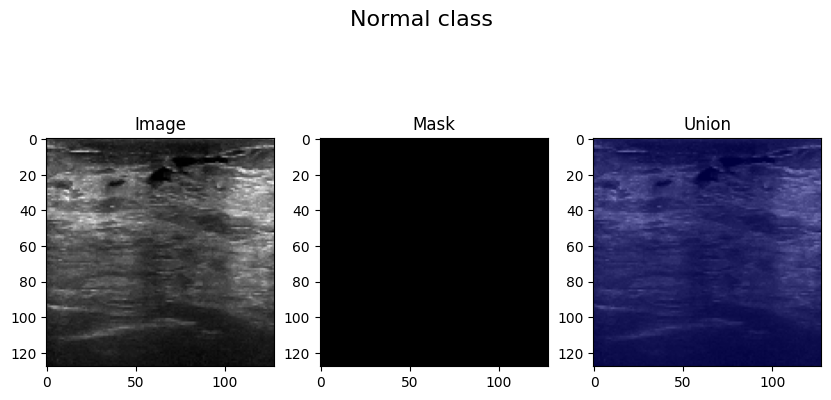

In [13]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:372] benign
# X[372:550] malignant
# X[550:663] normal

i = np.random.randint(550,663)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(Y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(Y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

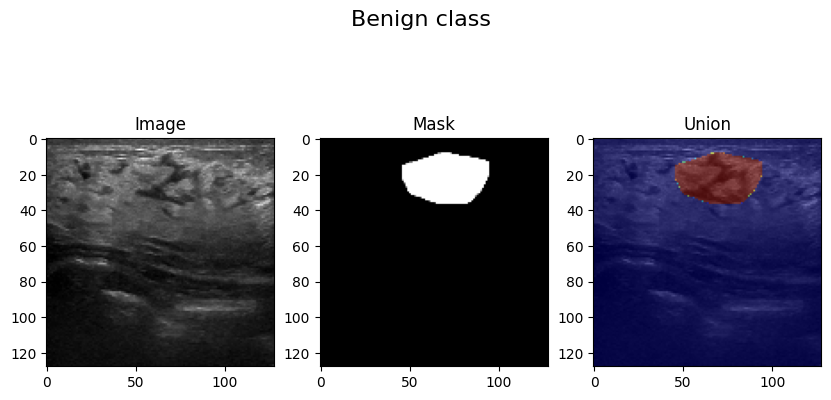

In [14]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(0,372)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(Y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(Y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

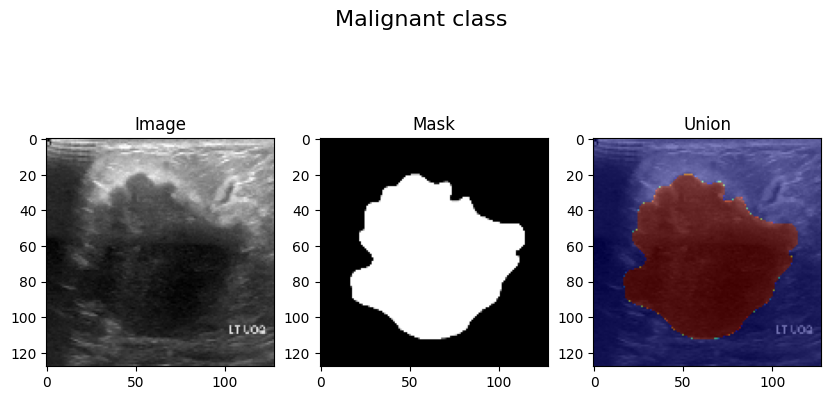

In [15]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(372,550)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(Y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(Y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

All classes

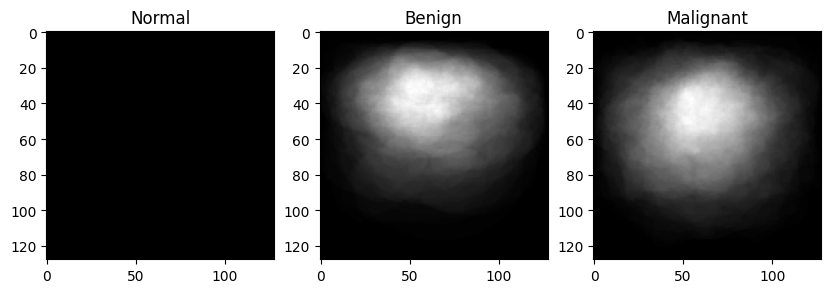

In [16]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(Y[550:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(Y[:372]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(Y[372:550]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

In [ ]:
import glob
import os

def load_data(root_path, size, augment_factor=5):
    files = sorted(glob.glob(root_path))
    for file in files:
        print(file) #print the files.
    #rest of the code.

load_data('/Users/sharonmwenda/Downloads/data/traindataset/*/*', 128, 5)

Augumented Data

In [19]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size, size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image / 255.
    return image

import tensorflow as tf

def augment(image, mask):
    image = tf.image.convert_image_dtype(image[..., tf.newaxis], dtype=tf.float32)
    mask = tf.image.convert_image_dtype(mask[..., tf.newaxis], dtype=tf.float32)

    # Generate random values once
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    flip_lr = tf.random.uniform(shape=[]) > 0.5
    flip_ud = tf.random.uniform(shape=[]) > 0.5
    brightness_delta = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)
    contrast_lower = tf.random.uniform(shape=[], minval=0.8, maxval=1.0)
    contrast_upper = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)

    # Apply transformations using the same random values
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    if flip_lr:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if flip_ud:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    image = tf.image.adjust_brightness(image, delta=brightness_delta)
    image = tf.image.adjust_contrast(image, contrast_factor=tf.random.uniform(shape=[], minval=contrast_lower, maxval=contrast_upper))

    image = tf.clip_by_value(image, 0.0, 1.0)
    image = image.numpy().squeeze()
    mask = mask.numpy().squeeze()
    return image, mask

def load_data(root_path, size):
    images = []
    masks = []
    x = 0

    files = sorted(glob(root_path))
    for path in files:
        img = load_image(path, size)

        if 'mask' in path:
            if x:
                masks[-1] += img
                masks[-1] = np.array(masks[-1] > 0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1
        else:
            images.append(img)
            x = 0

    return np.array(images), np.array(masks)

def augment_data(images, masks, augment_factor=5):
    augmented_images = []
    augmented_masks = []

    for i in range(len(images)):
        augmented_images.append(images[i])
        augmented_masks.append(masks[i])
        for _ in range(augment_factor):
            img_aug, mask_aug = augment(images[i], masks[i])
            augmented_images.append(img_aug)
            augmented_masks.append(mask_aug)

    return np.array(augmented_images), np.array(augmented_masks)

# Example usage
size = 128
augment_factor = 10

# Load the original data
#X, Y = load_data('/Users/sharonmwenda/Downloads/data/traindataset/*/*', size)
X, Y = load_data('/content/drive/MyDrive/data/traindataset/*/*', size)

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

# Augment the training data
X_train_aug, Y_train_aug = augment_data(X_train, Y_train, augment_factor)

# Print shapes
print("Original Images shape:", X.shape)
print("Original Masks shape:", Y.shape)
print("Augmented Training Images shape:", X_train_aug.shape)
print("Augmented Training Masks shape:", Y_train_aug.shape)
print("Validation Images shape:", X_val.shape)
print("Validation Masks shape:", Y_val.shape)

Original Images shape: (663, 128, 128)
Original Masks shape: (663, 128, 128)
Augmented Training Images shape: (6193, 128, 128)
Augmented Training Masks shape: (6193, 128, 128)
Validation Images shape: (100, 128, 128)
Validation Masks shape: (100, 128, 128)


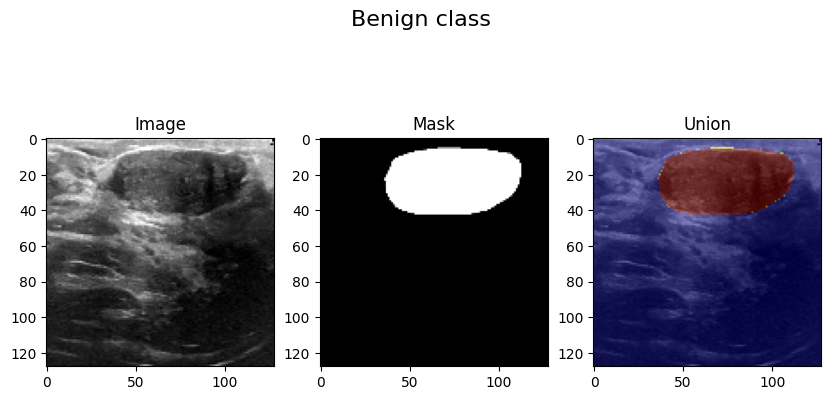

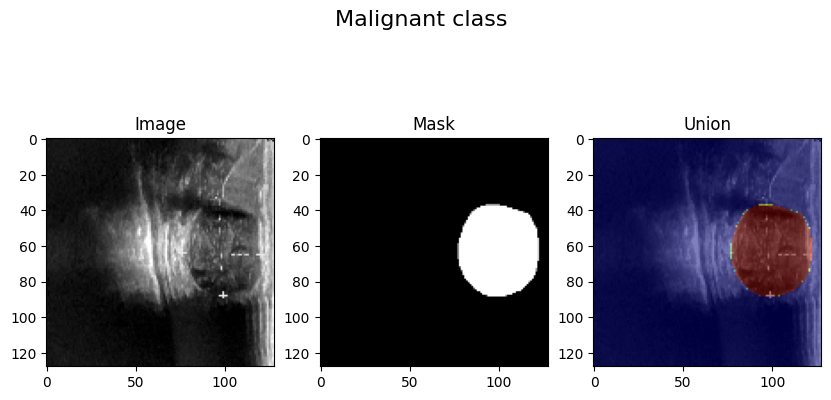

IndexError: index 7149 is out of bounds for axis 0 with size 6193

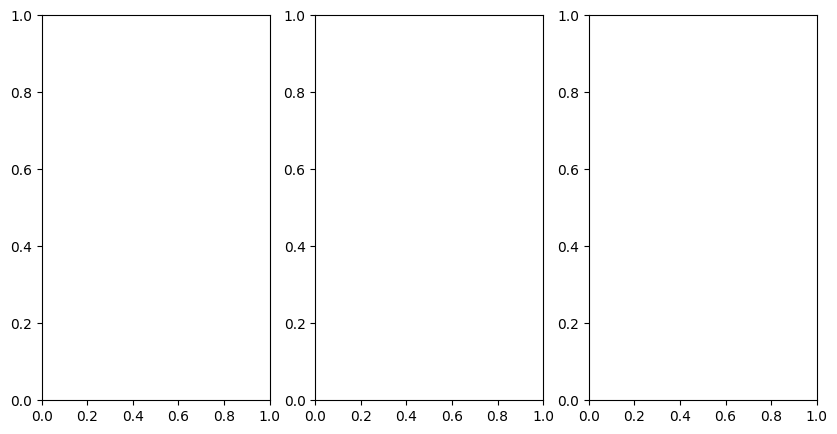

In [21]:
# Assuming your dataset is structured as:
# X[0:benign_end] benign
# X[benign_end:malignant_end] malignant
# X[malignant_end:normal_end] normal

benign_end = 372 * (augment_factor + 1)
malignant_end = 550 * (augment_factor + 1)
normal_end = 663 * (augment_factor + 1)

def plot_example(X, Y, start_index, end_index, class_name):
    i = np.random.randint(start_index, end_index)
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(X[i], cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(Y[i], cmap='gray')
    ax[1].set_title('Mask')
    ax[2].imshow(X[i], cmap='gray')
    ax[2].imshow(tf.squeeze(Y[i]), alpha=0.5, cmap='jet')
    ax[2].set_title('Union')
    fig.suptitle(f'{class_name} class', fontsize=16)
    plt.show()

# Plot examples for each class
plot_example(X_train_aug, Y_train_aug, 0, benign_end, 'Benign')
plot_example(X_train_aug, Y_train_aug, benign_end, malignant_end, 'Malignant')
plot_example(X_train_aug, Y_train_aug, malignant_end, normal_end, 'Normal')

Data Pre processing

In [22]:
#drop normal class because normal class has no mask
#X = X[:550]
#Y = Y[:550]

print(f'X shape: {X_train_aug.shape} \nY shape: {Y_train_aug.shape}')

# prepare data to modeling
X_train = np.expand_dims(X_train_aug, -1)
Y_train = np.expand_dims(Y_train_aug, -1)

X_val = np.expand_dims(X_val, -1)
Y_val = np.expand_dims(Y_val, -1)

print(f"\nX shape: {X_train.shape}  |  y shape: {Y_train.shape}")
print(f"\nX shape: {X_val.shape}  |  y shape: {Y_val.shape}")

X shape: (6193, 128, 128) 
Y shape: (6193, 128, 128)

X shape: (6193, 128, 128, 1)  |  y shape: (6193, 128, 128, 1)

X shape: (100, 128, 128, 1)  |  y shape: (100, 128, 128, 1)


Train-test split

In [23]:
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',Y_train.shape)
print('X_test shape:',X_val.shape)
print('y_test shape:',Y_val.shape)


X_train shape: (6193, 128, 128, 1)
y_train shape: (6193, 128, 128, 1)
X_test shape: (100, 128, 128, 1)
y_test shape: (100, 128, 128, 1)


Building U-Net Model

Conv block

In [24]:
#Batch normalization helps by normalizing the activations of the previous layer for each mini-batch
#during training, making the network less sensitive to the scale of the input data and improving
#convergence. It also introduces a regularizing effect that can reduce overfitting.

def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    return conv

Encoder Block

In [25]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

Decoder block

In [26]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

Build Model

In [27]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    #if trained for multi classification
    #output_layer = Conv2D(3, 1, padding="same", activation="softmax")(d4)


    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
#model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
#for multiclass classification
#model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

Learning rate using Learning Rate Scheduler in keras

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_lr_schedule(epoch, initial_lr=0.001, drop_rate=0.5, epochs_drop=10):
    """
    Step learning rate schedule.

    Args:
        epoch: Current epoch number.
        initial_lr: Initial learning rate.
        drop_rate: Factor by which to reduce the learning rate.
        epochs_drop: Number of epochs after which to drop the learning rate.

    Returns:
        The updated learning rate.
    """
    if epoch > 0 and epoch % epochs_drop == 0:
        return initial_lr * drop_rate
    else:
        return initial_lr

# Create a LearningRateScheduler callback
step_lr = LearningRateScheduler(step_lr_schedule)

# Compile the model
initial_learning_rate = 0.001 #set initial learning rate.
optimizer = Adam(learning_rate=initial_learning_rate)
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Learning Rate using Step LR

In [57]:
import tensorflow
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import AdamW

initial_lr = 0.0001
gamma = 0.9
step_size = 15

def step_decay(epoch):
    return initial_lr * (gamma ** (epoch // step_size))

class PrintLRS(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"Epoch {epoch+1}: Learning rate is {lr:.6f}")

lr_scheduler = LearningRateScheduler(step_decay)

optimizer=AdamW(learning_rate=0.0001, weight_decay=0.0001)

In [58]:
@tf.function(experimental_relax_shapes=True)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

@tf.function(experimental_relax_shapes=True)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

@tf.function(experimental_relax_shapes=True)
def iou_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

@tf.function(experimental_relax_shapes=True)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

@tf.function(experimental_relax_shapes=True)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

@tf.function(experimental_relax_shapes=True)
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

# Example usage (assuming you have a 'model' defined)
#learning_rate = 0.0001 #define learning rate.
#optimizer = Adam(learning_rate=learning_rate) #pass learning rate into Adam optimizer.



In [59]:


model.compile(
    loss=dice_loss,
    optimizer=optimizer,
    metrics=[
        'accuracy',
        iou_coefficient,
        dice_coefficient,
        precision,
        f1_score,
    ],
)



Model plotting

In [ ]:
model.summary()

# Training

In [ ]:
# Train the model with the callback
history = model.fit(
    X_train,
    Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, PrintLRS()]
)

In [ ]:
history_2 = model.fit(
    X_train,
    Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, PrintLRS()]
)

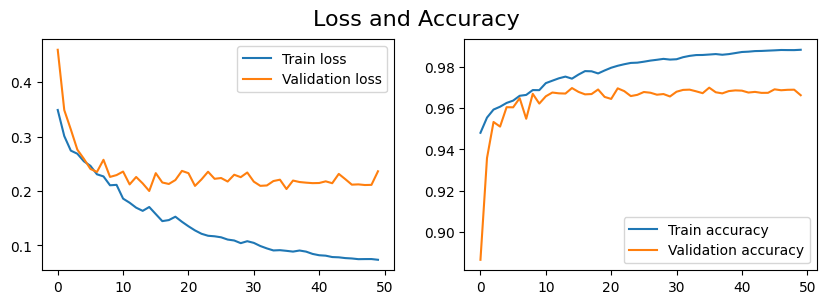

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots the training history (loss and all metrics)."""

    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    num_metrics = len(metrics)

    fig, axes = plt.subplots(num_metrics, 1, figsize=(8, num_metrics * 4)) #create vertical subplots

    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        ax = axes[i]

        ax.plot(history.epoch, history.history[metric], label=f"Train {metric}")
        if f"val_{metric}" in history.history:
            ax.plot(history.epoch, history.history[f"val_{metric}"], label=f"Validation {metric}")
        ax.legend()
        ax.set_title(metric)

    fig.suptitle('Training Metrics', fontsize=16)
    plt.tight_layout()
    plt.show()

# Assuming you have a 'history' object from model.fit()
plot_training_history(history)

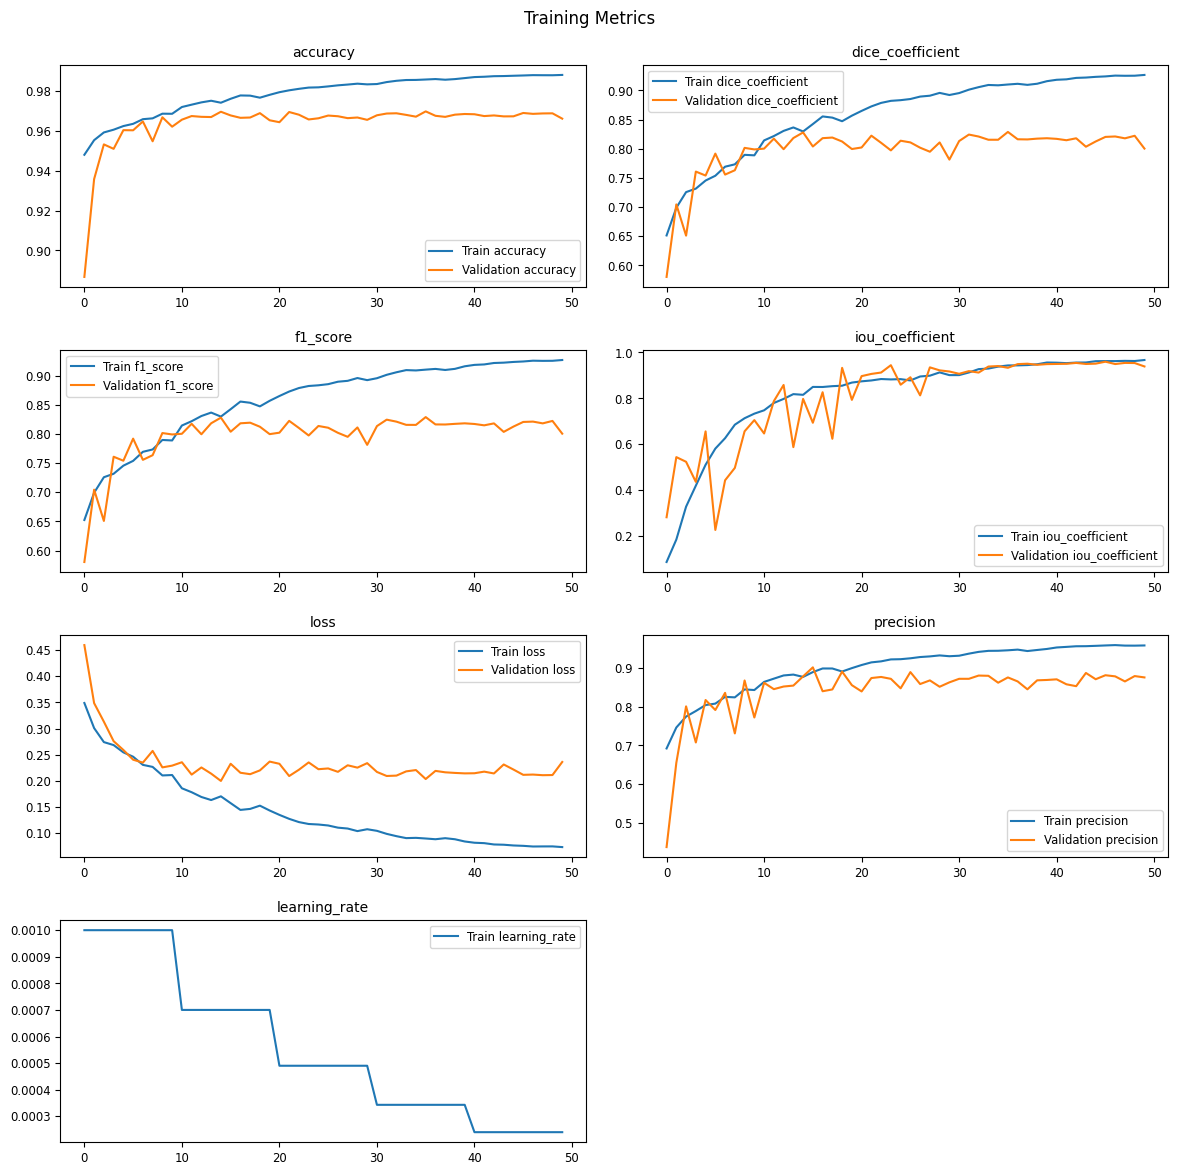

In [41]:
import matplotlib.pyplot as plt
import math

def plot_training_history(history):
    """Plots the training history (loss and all metrics) with 2 graphs per row."""

    metrics = [metric for metric in history.history.keys() if not metric.startswith('val_')]
    num_metrics = len(metrics)

    cols = 2
    rows = math.ceil(num_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3))  # Adjust figsize

    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        row = i // cols
        col = i % cols

        ax = axes[row, col] if rows > 1 else axes[col] if cols > 1 else axes #handles single metric.

        ax.plot(history.epoch, history.history[metric], label=f"Train {metric}", linewidth=1.5)
        if f"val_{metric}" in history.history:
            ax.plot(history.epoch, history.history[f"val_{metric}"], label=f"Validation {metric}", linewidth=1.5)
        ax.legend(fontsize='small')
        ax.set_title(metric, fontsize='medium')
        ax.tick_params(axis='both', labelsize='small')

    # Remove empty subplots if num_metrics is odd
    if num_metrics % cols != 0:
        axes[-1, -1].axis('off') if rows > 1 else axes[-1].axis('off')

    fig.suptitle('Training Metrics', fontsize=12)
    plt.tight_layout(pad=1.5)
    plt.show()

# Assuming you have a 'history' object from model.fit()
plot_training_history(history)

# Evaluation

# Load test dataset

In [42]:
size= 128
#X_test, Y_test = load_data('/Users/sharonmwenda/Downloads/data/testdataset/*/*', size)
X_test, Y_test = load_data('/content/drive/MyDrive/data/testdataset/*/*', size)

In [43]:
print(f'X shape: {X_test.shape} \nY shape: {Y_test.shape}')

X shape: (117, 128, 128) 
Y shape: (117, 128, 128)


In [44]:
X_test = np.expand_dims(X_test, -1)
Y_test = np.expand_dims(Y_test, -1)

print(f"\nX shape: {X_test.shape}  |  y shape: {Y_test.shape}")


X shape: (117, 128, 128, 1)  |  y shape: (117, 128, 128, 1)


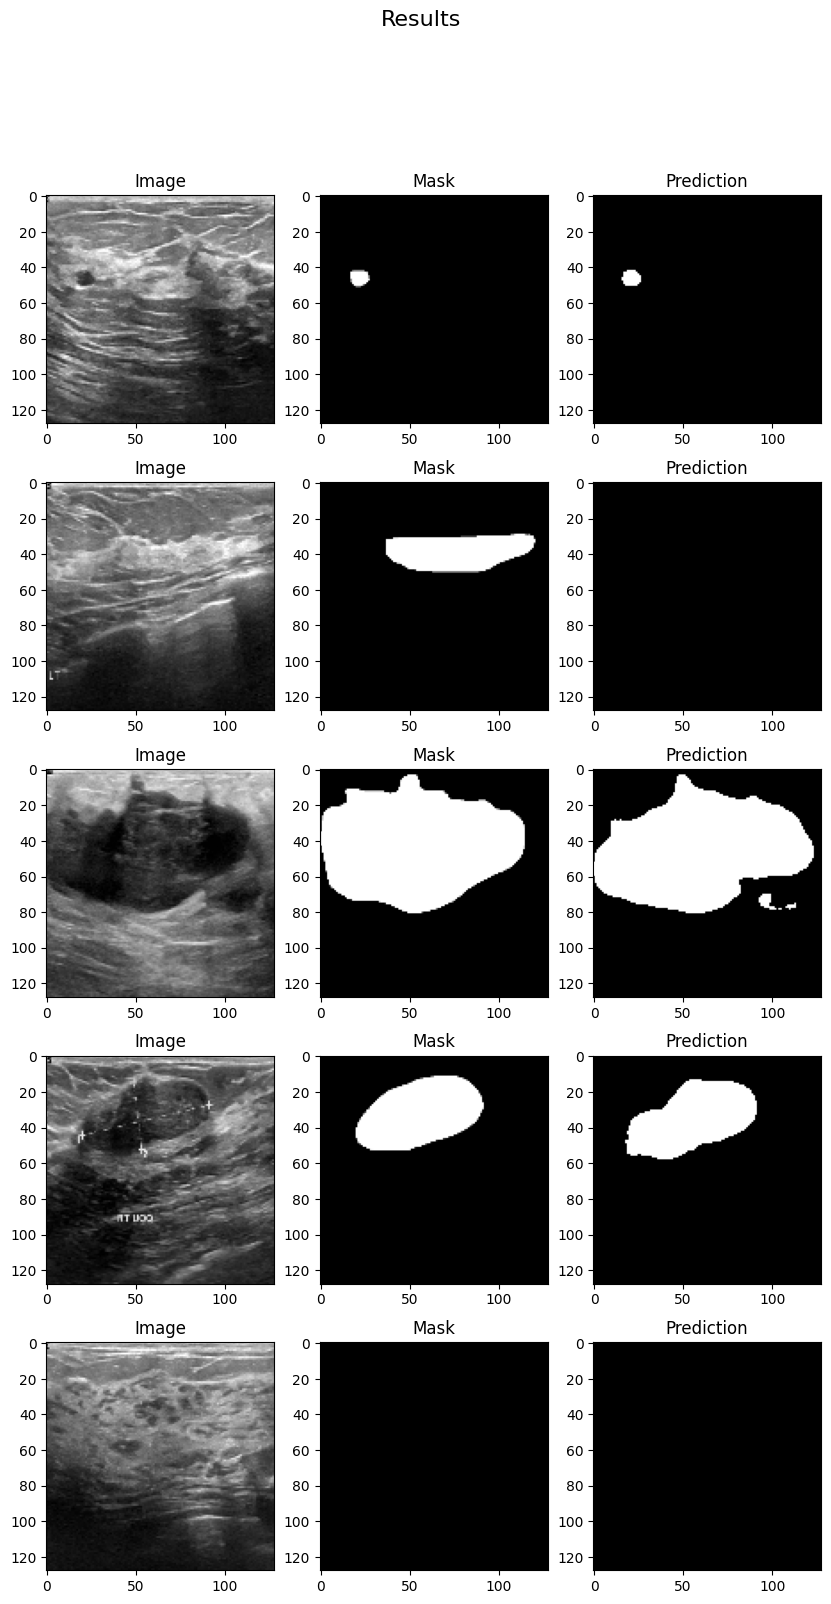

In [46]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(Y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    #model accepts batch of images
    predicted_mask = model.predict(np.expand_dims(X_test[j[i]], 0), verbose=0)[0] #adds an extra dimension to the image to form a batch of size 1.
    binary_mask = (predicted_mask > 0.5).astype('float32')  # Apply threshold
    ax[i,2].imshow(binary_mask, cmap='gray')
    ax[i,2].set_title('Prediction')

fig.suptitle('Results', fontsize=16)
plt.show()

Metrics

In [48]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5
# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, Y_test)
print("Mean IoU =", IOU_keras.result().numpy())


#- Precision is the ratio of correctly predicted positive pixels to the total number of pixels
#predicted as positive (true positives / predicted positives).

#- Recall is the ratio of correctly predicted positive pixels to all pixels that are actually positive (true positives / actual positives).

#- The F1 score is the harmonic mean of precision and recall, providing a balance between the two. It is a good metric when you want to balance between false positives and false negatives.

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, Y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, Y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

#dice score
def dice_metric(y_true, y_pred_thresholded):
    intersection = np.sum(y_true * y_pred_thresholded)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred_thresholded))

# A score of  0 indicates no overlap
#A score of 1 indicates perfect overlap
dice_score = dice_metric(Y_test, y_pred_thresholded)
print('Dice Score = %.3f' % dice_score)


Mean IoU = 0.75395083
Precision Score = 0.604
Recall Score = 0.860
F1 Score = 0.710
Dice Score = 0.709
